# Traffic Camera: Detection and tracking


## Imports

We will start by importing a few libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os.path import join
from bboxprovider import BboxProvider
from tracklet import show_bbox, Tracklet
from yolo import YOLO

Using TensorFlow backend.


## Download 4K Traffic Cam Video

You will need **youtube-dl** to download the video. (You can ignore this step but still, you will need a video

In [2]:
!youtube-dl -f 313 MNn9qKG2UFI

[youtube] MNn9qKG2UFI: Downloading webpage
[youtube] MNn9qKG2UFI: Downloading video info webpage
[download] 4K Traffic camera video - free download now!-MNn9qKG2UFI.webm has already been downloaded

[download] 100% of 659.43MiB


## View first frame

We will use OpenCV and Matplotlib to view the very first frame:

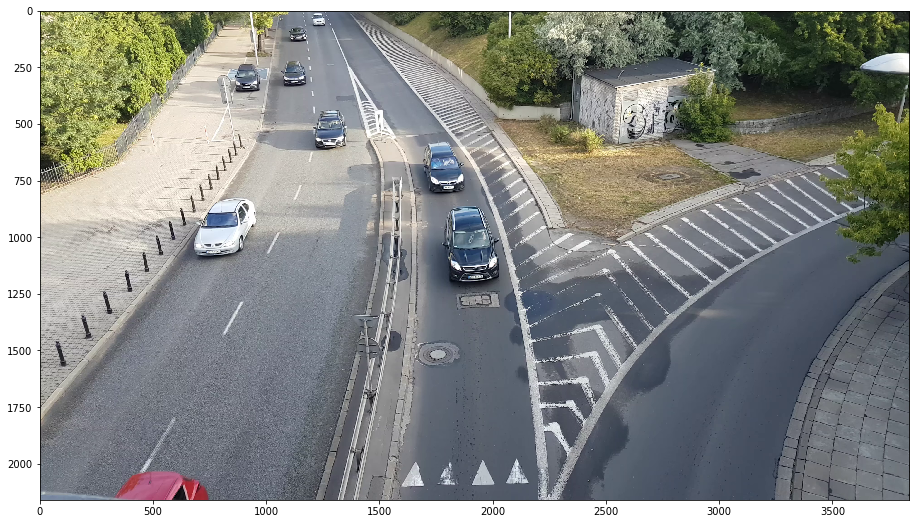

In [3]:
filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"
cap = cv2.VideoCapture(filename)
downscale = 1
while(True):
    ret, frame = cap.read()
    if not ret:
        break
        cv2.resize()
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (0,0), fx=1.0 / downscale, fy=1.0 / downscale) 
    break
    
cap.release()

plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

# Prepare YOLO network and generate initial bounding boxes for tracklets

In [4]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


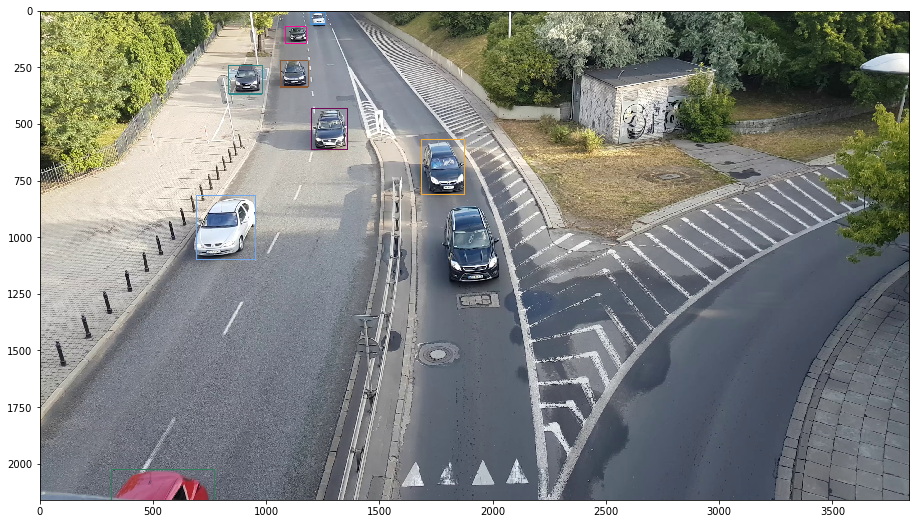

In [5]:
# params
tracker_factory = cv2.TrackerCSRT_create # used tracker
min_iou = 0.1 # min IOU to consider newly discovered box overlapping with existing in tracklet box
min_confidence = 0.5 # for YOLO box to be considered
padding = 3 # inflates the size of YOLO box

bbox_provider = BboxProvider(yolo, min_confidence=min_confidence,padding=padding)
boxes = bbox_provider.detect_boxes(frame, 0)
tracklets = [Tracklet(box, frame, tracker_factory=tracker_factory, min_iou=min_iou) for box in boxes]
for tracklet in tracklets:
    tracklet.show(frame,width=3)
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

# Load frames and propagate through them

In [ ]:
cap = cv2.VideoCapture(filename)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_filename = "temp.avi"
out = cv2.VideoWriter(output_filename, fourcc, fps, (width//downscale,height//downscale))

frames_count = 1800 # number of frames to process
yolo_update = fps # update 

for i in range(frames_count):
    ret, frame = cap.read()
    if not ret:
        break
        
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (0,0), fx=1.0 / downscale, fy=1.0 / downscale) 
    for tracklet in tracklets:
        tracklet.propagate(frame,i)
    
    if i % yolo_update == 0:
        print(i)
        boxes = bbox_provider.detect_boxes(frame, i)
        used_boxes = [tracklet.update(frame, boxes) for tracklet in tracklets]
        print(used_boxes)
        bb = []
        for x in used_boxes:
            bb += x
        bb = set(bb)
        unused_boxes = [box for i,box in enumerate(boxes) if i not in bb]
        new_tracklets = [Tracklet(box, frame, tracker_factory=tracker_factory, min_iou=min_iou) for box in unused_boxes]
        tracklets += new_tracklets
            
    # discards tracklets with no bbox found or bbox stepping outside of frame
    tracklets = [x for x in tracklets if not x.ended] 
    
    for tracklet in tracklets:
        tracklet.show(frame,width=2)
        
    out.write(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))

cap.release()
out.release()